# Cluster Progress

Load clusters from previous analysis and see the similarity of each cluster to H1-hESC.

In [139]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2)

In [2]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [4]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...


In [49]:
# Metadata file from previous run
metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')
metaData = metaData[order(metaData$sample_barcode), ]
head(metaData, 2)

,barcode,cluster,umap1,umap2,barcode.1,TN,UM,PP,UQ,CM,landmark,cluster.1,sample,sample_barcode
1206,AAACAACGACGATTAC,6,2.515876,8.252824,AAACAACGACGATTAC,42629,38455,38381,33575,51,0,6,D0,D0_AAACAACGACGATTAC
1207,AAACAACGACTCACGG,6,2.355841,7.403916,AAACAACGACTCACGG,4424,4009,3998,3694,4,0,6,D0,D0_AAACAACGACTCACGG


In [16]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [17]:
x.sp.list

$D0
number of barcodes: 11133
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 9724
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 8726
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 10566
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D8
number of barcodes: 9895
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 4105
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 6334
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 16287
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [18]:
bin.shared = Reduce(intersect, lapply(x.sp.list, function(x.sp) x.sp@feature$name));

In [19]:
# merge timepoints

x.sp.list <- lapply(x.sp.list, function(x.sp){
    idy = match(bin.shared, x.sp@feature$name);
    x.sp[,idy, mat="bmat"];
  })
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”

In [44]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [52]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap1", "umap2")])

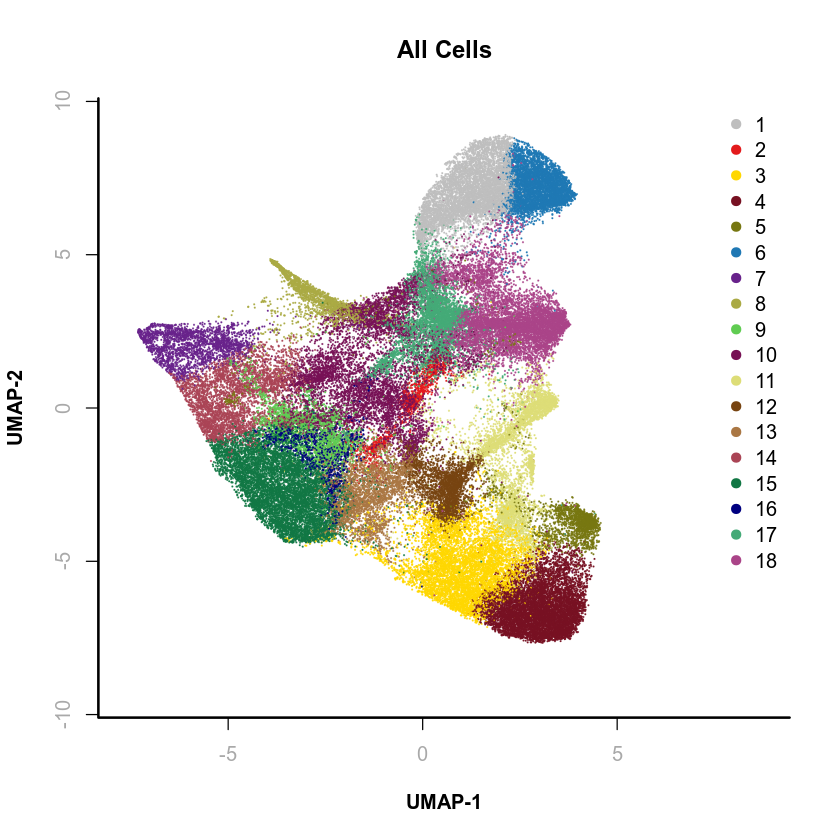

In [102]:
# verify all in order
plotViz(
    obj=x.sp,
    method="umap", 
    main="All Cells",
    point.color=x.sp@cluster, 
    point.size=0.1, 
    text.add= FALSE,
    down.sample=NULL,
    legend.add=TRUE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );

## Write Fragment for each cluster

In [86]:
writeClusterFragmentsToBed <- function(
    obj, 
    output.prefix,
    path.to.snaptools,
    buffer.size=500,
    num.cores=10
){
    fileList = as.list(unique(obj@file));
 
    # check if files are all snap files
    if(any(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)
        print("error: these files are not snap file")
        print(fileList[idx])
        stop()
    }
    
    # check if FM session exist
    if(any(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)
        print("error: the following nsap files do not contain FM session")
        print(fileList[idx])
        stop()
    }
        
    # write the following barcodes down
    barcode.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".barcode.txt");
    })

    bed.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".bed.gz");
    })
    
    # write down the barcodes
    cat("Epoch: extracting fragments from each snap files ...\n", file = stderr())
    flag.list = lapply(seq(fileList), function(i){
        file.name = fileList[[i]];
        idx = which(obj@file == file.name);
        barcode.use = obj@barcode[idx]
        message(barcode.files[[i]])
        message(bed.files[[i]])
        message(fileList[[i]])
        write.table(barcode.use, file = barcode.files[[i]], append = FALSE, quote = FALSE, sep = "\t",
                         eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                         col.names = FALSE, qmethod = c("escape", "double"),
                         fileEncoding = "")
        
    })

    # extract the fragments belong to the barcodes    
    flag.list = mclapply(seq(fileList), function(i){
        flag = system2(command=path.to.snaptools, 
            args=c("dump-fragment", 
                   "--snap-file", fileList[[i]], 
                   "--output-file", bed.files[[i]], 
                   "--barcode-file", barcode.files[[i]],
                   "--buffer-size", buffer.size
                   )        
            )                
    }, mc.cores=num.cores);
    
    # combine these bed files
    combined.bed = paste(output.prefix, ".bed.gz");
    flag = system2(command="cat", 
        args=c(paste(bed.files, collapse = ' '),
               ">", combined.bed
               )        
        )                
}

In [ ]:
cluster_names = names(table(x.sp@cluster))
# mclapply(seq(cluster_names), function(i){
#     print(cluster_names[i]);
#     writeClusterFragmentsToBed(
#         obj=x.sp[which(x.sp@cluster==cluster_names[i]),], 
#         output.prefix=paste0("./snapATAC_sessions/20200125_n76770/cluster_beds/idx", cluster_names[i]),
#         path.to.snaptools="/users/surag/anaconda3/envs/snapATAC/bin/snaptools",
#         buffer.size=500, 
#         num.cores=1
#    );
#  }, mc.cores=5);

In [90]:
# check bed files
# zcat .../cluster_idx12.bed.gz | cut -f4 | uniq | sort | uniq | head
head(sort(x.sp[which(x.sp@cluster==cluster_names[12])]@barcode))

[1] "AAACAACGATATCTGG" "AAACACGCTAGGCATG" "AAACACGCTATCATCG" "AAACACGCTCTGGGTC"
[5] "AAACACGCTGAGAGGG" "AAACATGGACGCCACA"

In [ ]:
# write control beds - same number of clusters and same size and same 
# number of cells per day per cluster
cluster_names = names(table(x.sp@cluster))

shuffled_structure_preserved_cluster = x.sp@cluster
for (d in DAYS) {
    shuffled_structure_preserved_cluster[x.sp@sample==d] = sample(shuffled_structure_preserved_cluster[x.sp@sample==d])
}

mclapply(seq(cluster_names), function(i){
    print(cluster_names[i]);
    writeClusterFragmentsToBed(
        obj=x.sp[which(shuffled_structure_preserved_cluster==cluster_names[i]),], 
        output.prefix=paste0("./snapATAC_sessions/20200125_n76770/shuffled_cluster_beds/cluster_idx", cluster_names[i]),
        path.to.snaptools="/users/surag/anaconda3/envs/snapATAC/bin/snaptools",
        buffer.size=500, 
        num.cores=1
   );
 }, mc.cores=10);

In [199]:
# verify all in order
# plotViz(
#     obj=x.sp,
#     method="umap", 
#     main="All Cells",
#     point.color=shuffled_structure_preserved_cluster, 
#     point.size=0.1, 
#     text.add= FALSE,
#     down.sample=NULL,
#     legend.add=TRUE,
# #     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
#   );

## Count Frags in Bin

To do this, repurposed existing scripts that count reads in bins. See `scripts/form_cluster_counts_matrix.sh`.

Ran the command


`
BASE=/users/surag/kundajelab/scATAC-reprog/src/analysis/;
bash form_cluster_counts_matrix.sh $BASE/20200122_snapATAC/snapATAC_sessions/20200125_n76770/matrix <(sed '1d' $BASE/20200118_Bulk_Analysis/data/bulk_from_pipeline/idr.counts.tsv) 18 $BASE/20200122_snapATAC/snapATAC_sessions/20200125_n76770/cluster_beds/cluster_idx $BASE/20200122_snapATAC/snapATAC_sessions/20200125_n76770/bulk_peakset_matrix/bulk.idr.cluster.counts.tsv
`

TODO: Do it with tagAligns (chop frags into 2 reads)

## Similarity Anaylsis

In [92]:
h1_atac_idr_intersect_peaks <- read.csv("../20200124_H1_progress/data/H1.hESC.atac.idr.bulk.idr.intersect.txt",sep="\t")
rownames(h1_atac_idr_intersect_peaks)=paste(h1_atac_idr_intersect_peaks$chrom,h1_atac_idr_intersect_peaks$start,h1_atac_idr_intersect_peaks$end,sep='\t')
h1_atac_idr_intersect_peaks$chrom = NULL
h1_atac_idr_intersect_peaks$start = NULL
h1_atac_idr_intersect_peaks$end = NULL
tail(head(h1_atac_idr_intersect_peaks, 10), 2)

,count
chr1 631001 631377,0
chr1 631814 632317,0


In [93]:
# binarize 
h1_atac_idr_intersect_peaks[,"count"] = ifelse(h1_atac_idr_intersect_peaks[,"count"] > 0, 1, 0)
tail(head(h1_atac_idr_intersect_peaks, 10), 2)

,count
chr1 631001 631377,0
chr1 631814 632317,0


In [97]:
# Cluster counts
cts <- read.csv("./snapATAC_sessions/20200125_n76770/bulk_peakset_matrix/bulk.idr.cluster.counts.tsv",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
chr1 51459 51659,1,0,2,2,0,0,0,0,0,1,0,0,2,1,0,0,0,1
chr1 51689 51889,1,1,10,10,0,1,0,0,0,0,1,0,5,1,2,0,0,0


[1] 230644     18

In [98]:
library(PRROC)

In [99]:
auprcs_to_idr = c()
for (y in colnames(cts)) {
    cur_auprc = pr.curve(cts[,y], 
                            weights.class0 = h1_atac_idr_intersect_peaks$count)$auc.davis.goadrich
    print(sprintf("%s : %4f", y, cur_auprc))
    auprcs_to_idr = c(auprcs_to_idr, cur_auprc)
}

[1] "cluster1 : 0.526066"
[1] "cluster2 : 0.591966"
[1] "cluster3 : 0.720938"
[1] "cluster4 : 0.736238"
[1] "cluster5 : 0.661443"
[1] "cluster6 : 0.537869"
[1] "cluster7 : 0.554499"
[1] "cluster8 : 0.555887"
[1] "cluster9 : 0.592488"
[1] "cluster10 : 0.576054"
[1] "cluster11 : 0.643957"
[1] "cluster12 : 0.661194"
[1] "cluster13 : 0.663841"
[1] "cluster14 : 0.581925"
[1] "cluster15 : 0.614183"
[1] "cluster16 : 0.575174"
[1] "cluster17 : 0.501080"
[1] "cluster18 : 0.526612"


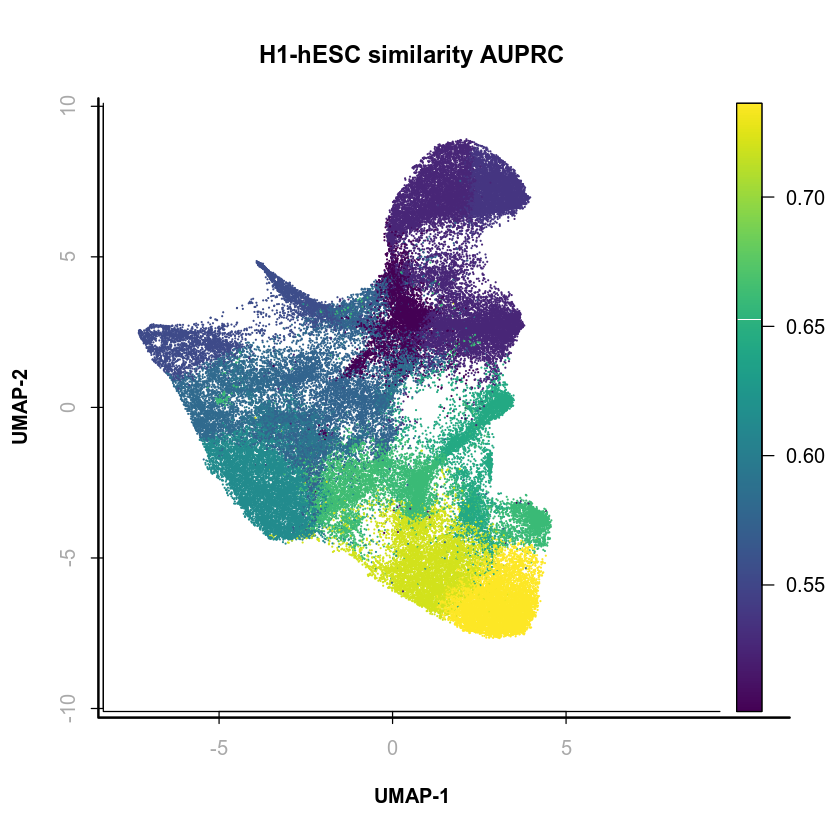

In [118]:
# verify all in order
plotFeatureSingle(
    obj=x.sp,
    method="umap", 
    main="H1-hESC similarity AUPRC",
    feature.value=auprcs_to_idr[x.sp@cluster], 
    point.size=0.05,
    down.sample=NULL
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  )

In [129]:
# auprc to cluster 1 (Fibroblasts)
corr_to_cluster1 = c()
for (y in colnames(cts)) {
    cur_corr = cor(cts[,y], cts$cluster1, method='spearman')
    print(sprintf("%s : %4f", y, cur_corr))
    corr_to_cluster1 = c(corr_to_cluster1, cur_corr)
}

[1] "cluster1 : 1.000000"
[1] "cluster2 : 0.810306"
[1] "cluster3 : 0.350782"
[1] "cluster4 : 0.357914"
[1] "cluster5 : 0.607441"
[1] "cluster6 : 0.981817"
[1] "cluster7 : 0.629383"
[1] "cluster8 : 0.752473"
[1] "cluster9 : 0.711265"
[1] "cluster10 : 0.793427"
[1] "cluster11 : 0.710524"
[1] "cluster12 : 0.556404"
[1] "cluster13 : 0.458094"
[1] "cluster14 : 0.567158"
[1] "cluster15 : 0.373661"
[1] "cluster16 : 0.512794"
[1] "cluster17 : 0.936969"
[1] "cluster18 : 0.954201"


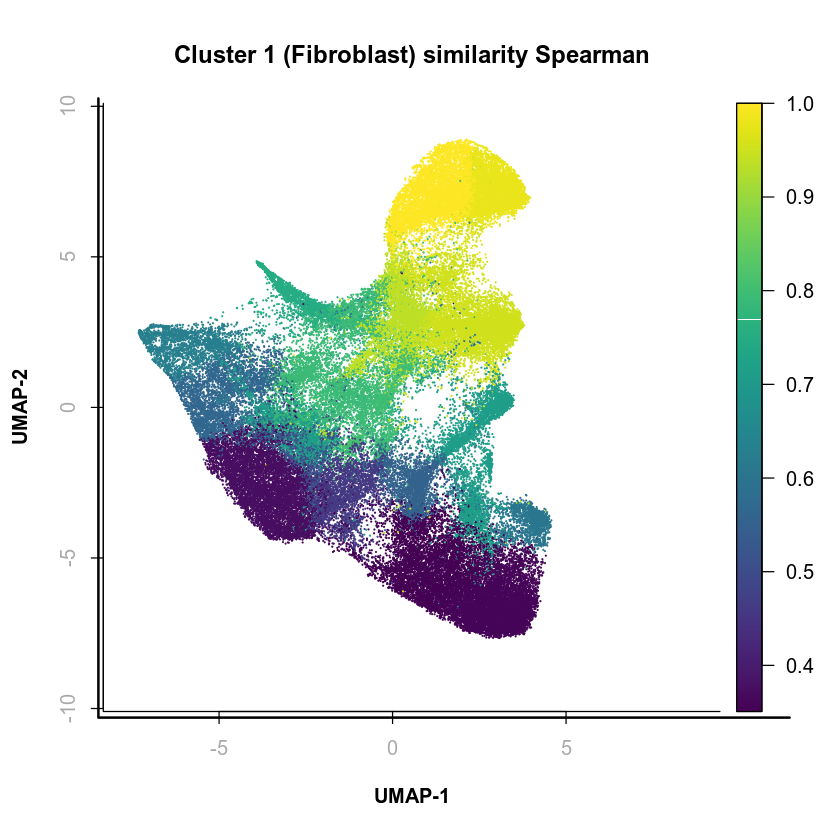

In [166]:
# verify all in order
plotFeatureSingle(
    obj=x.sp,
    method="umap", 
    main="Cluster 1 (Fibroblast) similarity Spearman",
    feature.value=corr_to_cluster1[x.sp@cluster], 
    point.size=0.05,
    down.sample=NULL
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  )

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


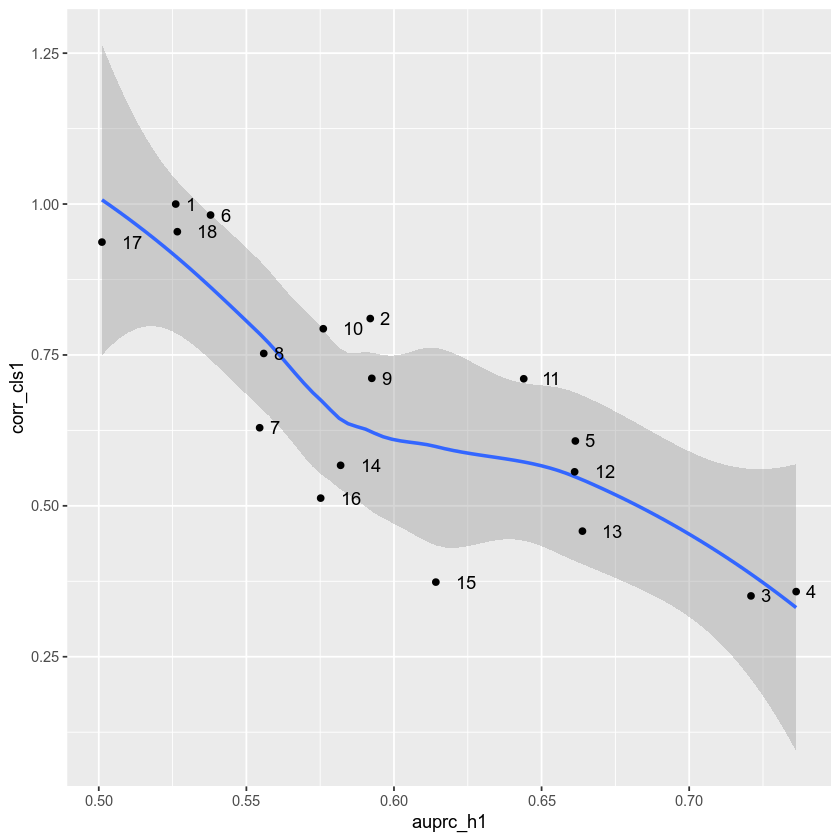

In [154]:
ggplot(data.frame(auprc_h1=auprcs_to_idr,
                  corr_cls1=corr_to_cluster1,
                  idx=seq(1,length(corr_to_cluster1))),
      aes(x=auprc_h1, y=corr_cls1)) +
geom_smooth() + 
geom_point() + 
geom_text(aes(label=idx), hjust=-1)

Warning message:
“Removed 8584 rows containing non-finite values (stat_binhex).”

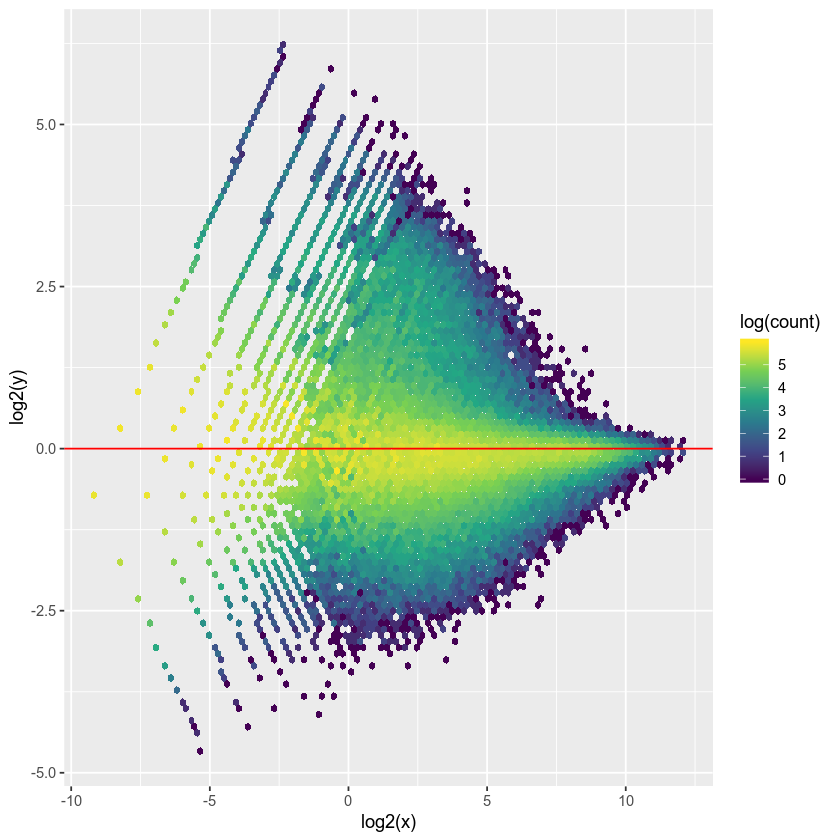

In [165]:
plot_lfc <- function(norm_matrix, S1, S2) {
    df = data.frame(y=(norm_matrix[,S1]/norm_matrix[,S2]),
                x=((norm_matrix[,S1]*norm_matrix[,S2])/2))
    p <- ggplot(df, aes(x=log2(x), y=log2(y))) + 
#     geom_point(alpha=0.1) +
    stat_binhex(aes(fill=log(..count..)), bins=100)+
    scale_fill_viridis_c() + 
#     coord_cartesian(xlim=c(0, 8)) +
    geom_abline(slope=0, col="red")
    p
}

# seems like iPSCs have more open sites...check diff peaks!
plot_lfc(1000000*t(t(cts)/colSums(cts)), "cluster7", "cluster8")